In [2]:
# setup
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.integrate

In [4]:
def run_sim_2d(N0, M0, gen_fn, ngens, dtype='int', **kwargs):
    assert(len(N0) == len(M0))
    N = np.empty((ngens, len(N0)), dtype=dtype)
    N[0, :] = N0
    M = np.empty((ngens, len(M0)), dtype=dtype)
    M[0, :] = M0
    for t in range(1, ngens):
        N[t, :], M[t, :] = gen_fn(N[t-1, :], M[t-1, :], **kwargs)
    return N, M


# Species interactions, with linear algebra

Let's go back to our Lotka-Volterra-like model,
with deterministic equations:

$$\begin{aligned}
  \mathbb{E}[N_{t+1} | N_t = N, M_t = M]
      &= F(N, M) \\
      &= N (1 - p_0) + p_0 N \lambda_0 \exp(- (N + a_0 M)/K_0) \\
  \mathbb{E}[M_{t+1} | N_t = N, M_t = M]
      &= G(N, M) \\
      &= M (1 - p_1) + p_1 M \lambda_1 \exp(- (M + a_1 N)/K_1) .
\end{aligned}$$

which has an equilibrium at
$$\begin{aligned}
  N_* &= \frac{K_0 \log(\lambda_0) - a_0 K_1 \log(\lambda_1)}{1 - a_0 a_1} \\
  M_* &= \frac{K_1 \log(\lambda_1) - a_1 K_0 \log(\lambda_0)}{1 - a_0 a_1} .
\end{aligned}$$

We'd like to *linearize* about this fixed point
and use what we learned about linear algebra
to figure out what this model does there.

Then, we know that $F(N_*, M_*) - N_* = G(N_*, M_*) - M_* = 0$,
and hence that
$$
    \frac{1 - p_0}{p_0 \lambda_0} = \exp(-(N_* + a_0 M_*) / K_0) ,
$$
a fact that will come in handy in a minute.

We'd like to find the eigenvalues of the 2x2 matrix
$$\begin{aligned}
A
=
\begin{bmatrix}
\frac{dF}{dN}(N_*, M_*) - 1 & \frac{dF}{dM}(N_*, M_*) \\
\frac{dG}{dN}(N_*, M_*) & \frac{dG}{dM}(N_*, M_*) - 1
\end{bmatrix}
\end{aligned}$$
The first entry in this matrix is, using the identity above:

$$\begin{aligned}
  \frac{dF}{dN}(N_*, M_*)
  &=
  (1 - p_0) + p_0 \lambda_0 \left( 1 - \frac{N_*}{K_0} \right) \exp\left(-\frac{N_* + a_0 M_*}{K_0}\right) \\
  &= 
  (1 - p_0)\left( 2 - \frac{N_*}{K_0} \right)  - 1.
\end{aligned}$$

The second entry is:

$$\begin{aligned}
  \frac{dF}{dM}(N_*, M_*)
  &=
  a_0 p_0 \lambda_0 \frac{N_*}{K_0} \exp\left(-\frac{N_* + a_0 M_*}{K_0}\right) \\
  &= 
  a_0 (1 - p_0)\frac{N_*}{K_0} .
\end{aligned}$$

So, by symmetry,
$$\begin{aligned}
A
=
\begin{bmatrix}
  (1 - p_0)\left( 2 - \frac{N_*}{K_0} \right)  - 1
  &
    a_0 (1 - p_0)\frac{N_*}{K_0} 
    \\
    a_1 (1 - p_1)\frac{M_*}{K_1} 
  &
  (1 - p_1)\left( 2 - \frac{M_*}{K_1} \right)  - 1
\end{bmatrix} .
\end{aligned}$$

That will tell us about stability at $(N_*, M_*)$.
However, we also need to know about stability at the other fixed points:
let's call them $(N_\dagger, 0)$ and $(0, M_\dagger)$.

These are (again from the previous document):
$$\begin{aligned}
N_\dagger &= K_0 \log \lambda_0 \\
M_\dagger &= K_1 \log \lambda_1
\end{aligned}$$
and here we have
$$\begin{aligned}
A_\dagger
&=
\begin{bmatrix}
  (1 - p_0)\left( 2 - \frac{N_\dagger}{K_0} \right)  - 1
  &
    a_0 (1 - p_0)\frac{N_\dagger}{K_0} 
    \\
    a_1 (1 - p_1)\frac{M_\dagger}{K_1} 
  &
  (1 - p_1)\left( 2 - \frac{M_\dagger}{K_1} \right)  - 1
\end{bmatrix} \\
&=
\begin{bmatrix}
  (1 - p_0)\left( 2 - \log \lambda_0 \right)  - 1
  &
    a_0 (1 - p_0)\log \lambda_0
    \\
    a_1 (1 - p_1)\log \lambda_1
  &
  (1 - p_1)\left( 2 - \log \lambda_1 \right)  - 1
\end{bmatrix}
\end{aligned}$$

In [60]:
def lv_equil(lam, p, K, a):
    return np.array([K[0] * np.log(lam[0]) - a[0] * K[1] * np.log(lam[1]),
                     K[1] * np.log(lam[1]) - a[1] * K[0] * np.log(lam[0])]) / (1 - a[0] * a[1])

def lv_Amat(lam, p, K, a):
    equil = lv_equil(lam, p, K, a)
    return (
        np.array([
            [
                (1 - p[0]) * (2 - equil[0] / K[0]) - 1,
                a[0] * (1 - p[0]) * equil[0] / K[0]
            ],
            [
                (1 - p[1]) * (2 - equil[1] / K[1]) - 1,
                a[1] * (1 - p[1]) * equil[1] / K[1]
            ],
            ]),
        np.array([
            [
                (1 - p[0]) * (2 - np.log(lam[0])) - 1,
                a[0] * (1 - p[0]) * np.log(lam[0])
            ],
            [
                (1 - p[1]) * (2 - np.log(lam[1])) - 1,
                a[1] * (1 - p[1]) * np.log(lam[1])
            ],                
        ])
    )

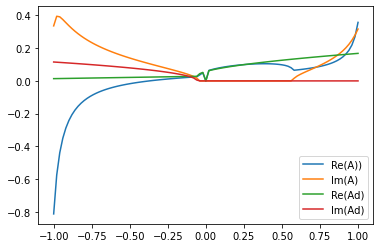

In [73]:
lv_args = {
        'lam' : [1.2 * 0.9, 0.9],    # fecundity
        'p' : [0.5 * 0.9, 0.9 * 0.9],      # survival prob
        'K' : [2000, 5000],      # carrying capacity
        'a' : [-0.6, -1.5]  # encounter rate
    }

xvals = np.linspace(-1, 1, 101)
eee = np.zeros(len(xvals), dtype="complex")
eed = np.zeros(len(xvals), dtype="complex")
for j, x in enumerate(xvals):
    args = lv_args.copy()
    args['a'] = [y * x for y in lv_args["a"]]
    A, Ad = lv_Amat(**args)
    evals, _ = np.linalg.eig(A)
    eee[j] = evals[0]
    evals, _ = np.linalg.eig(Ad)
    eed[j] = evals[0]

fig, ax = plt.subplots()
ax.plot(xvals, np.real(eee), label="Re(A))")
ax.plot(xvals, np.imag(eee), label="Im(A)")
ax.plot(xvals, np.real(eed), label="Re(Ad)")
ax.plot(xvals, np.imag(eed), label="Im(Ad)")
ax.legend();

In [39]:
del pvals
del lvals

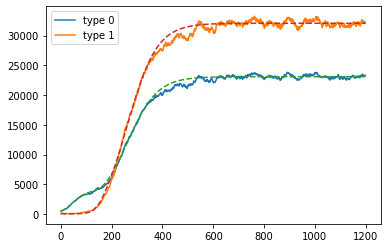

In [86]:
def lv_eqn(N, M, lam, p, K, a):
    # this is F and G, the deterministic equations
    next_N = N + p[0] * N * (lam[0] * np.exp(-(N + a[0] * M)/K[0]) - 1)
    next_M = M + p[1] * M * (lam[1] * np.exp(-(M + a[1] * N)/K[1]) - 1)
    return next_N, next_M

def lv_gen(N, M, lam, p, K, a):
    # this is simulating as described above
    assert(len(M) == len(N))
    N_dies = np.random.binomial(N, p[0])
    M_dies = np.random.binomial(M, p[1])
    N_repro = np.random.poisson(N_dies * lam[0] * np.exp(-((N + a[0]*M)/K[0])))
    M_repro = np.random.poisson(M_dies * lam[1] * np.exp(-((M + a[1]*N)/K[1])))
    next_N = N - N_dies + N_repro
    next_M = M - M_dies + M_repro
    return next_N, next_M

lv_args = {
        'lam' : [1.2 * 0.9, 0.95],    # fecundity
        'p' : [0.5, 0.9],      # survival prob
        'K' : [50000, 50000],      # carrying capacity
        'a' : [-0.6, -1.5]  # encounter rate
    }

# random simulation
N, M = run_sim_2d([500], [100], lv_gen, 1200, dtype='int',
                    **lv_args)
# deterministic
tN, tM = run_sim_2d([500], [100], lv_eqn, 1200, dtype='float',
                    **lv_args)

fig, ax = plt.subplots()
ax.plot(np.column_stack([N, M]), label=["type 0", "type 1"])
ax.plot(np.column_stack([tN, tM]), linestyle="--")
ax.legend();